# Towards an ICCM paper

This notebook will have two parts. The first will make predictions about reading times (to start, for local coherence effects) from the equations of motion. The second will test the hypothesis that, in the model, the average reading time is monotonically dependent on the relative harmony values of two competing peaks.

To test both of these ideas, we'll use a 2D harmony landscape with two attractors, one at [1, 0] and the other at [0, 1]. The attractor at [1, 0] will be the grammatical parse $\mathbf{x}_g$, and [0, 1] will be the ungrammatical parse $\mathbf{x}_u$.

## Part the first: A line integral approach to predicting reading times

(This is taken largely from [here](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsPtI.aspx) and Boas (1983, *Mathematical methods in the physical sciences*, Wiley).

The time to travel some distance along a curve $C$ is equal to the distance traveled divided by the speed of travel. Thus, we're looking for an equation of the form $T = dist / speed$. In the general case of $n$-dimensions, this will be a path integral $T = \int_C \mathbf{F}\cdot d\mathbf{r}$, where $\mathbf{F}$ is some vector field and $d\mathbf{r}$ is derivative along the curve $C$, where $C$ has been parameterized using some function $\mathbf{r}(t)$. Ideally, we would define the curve $C$ to be the actual path defined by the dynamics, but that would require an explicit solution to the differential equation $\dot{\mathbf{x}} = \nabla H(\mathbf{x})$, which we don't have. Instead, I'm approximating the actual solution curve with a straight line connecting the initial state $\mathbf{x}_{init}$ and some final state $\mathbf{x}_{fin}$ close to $\mathbf{x}_g$ or $\mathbf{x}_u$.

We want to see how long it takes to get from $\mathbf{x}_{init}$ to $\mathbf{x}_{fin}$, so the force $\mathbf{F}$ from above becomes $\nabla H(\mathbf{x})^{-1}$:
$$
T = \int_C \nabla H(\mathbf{x})^{-1}\cdot d\mathbf{r}
$$
We need to make $H(\cdot)^{-1}$ a function of the 1D position along the curve, so that means writing each element $x_j$ of the state vector $\mathbf{x}$ as function of that position. This position along the curve is given by 
$$
\mathbf{r}(t) = (1 - t)\mathbf{x}_{init} + t\mathbf{x}_{fin}
$$
for $0 \leq t \leq 1$. Note that this parameterization equals $\mathbf{x}_{init}$ at $t = 0$ and $\mathbf{x}_{fin}$ at $t = 1$. With 
$$
d\mathbf{r} = (-\mathbf{x}_0 + \mathbf{x}_1) dt
$$
the integral becomes
$$
T = \int_0^1 \left(\nabla H(\mathbf{r}(t))^{-1}\cdot (-\mathbf{x}_0 + \mathbf{x}_1)\right)dt
$$
which can be evaluated numerically.

In [1]:
# Setting up things in SymPy
from sympy import *
from IPython.display import display

# Declaring scalars
# x0, x1 are the dimensions
x0, x1, h0, h1, gamma, t = symbols('x0 x1 h0 h1 gamma t')  # make these formal symbols for SymPy to manipulate
# x{0, 1}{i, f} are the initial and final positions for the two spatial dimensions
x0i, x1i, x0f, x1f = symbols('x0i x1i x0f x1f')
h0 = 1.0
h1 = 0.5  # For initial testing
gamma = 0.25

# Declaring vectors
x = Matrix([x0, x1])  # state vector
cg = Matrix([1, 0])  # centers of the RBFs
cu = Matrix([0, 1])
xinit = Matrix([x0i, x1i])  # placeholders for now
xfin = Matrix([x0f, x1f])
t1 = Matrix([1-t, 1-t])  # Vectors for calculating r(t)
justt = Matrix([t, t])

H = h0*exp(-(x-cg).dot(x-cg) / gamma) + h1*exp(-(x-cu).dot(x-cu) / gamma)  # defining the harmony function
dxdt = Matrix([diff(H, i) for i in x])
r = xinit.multiply_elementwise(t1) + xfin.multiply_elementwise(justt)
dr = (-xinit + xfin)
display(H, dxdt, r, dr)

0.5*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)

Matrix([
[-4.0*x0*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*(-8.0*x0 + 8.0)*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)],
[-8.0*x1*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2) + 0.5*(-8.0*x1 + 8.0)*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2)]])

Matrix([
[t*x0f + x0i*(-t + 1)],
[t*x1f + x1i*(-t + 1)]])

Matrix([
[x0f - x0i],
[x1f - x1i]])

In [2]:
# Calculating the locations of the fixed points
xg = nsolve(dxdt, x, (1, 0))
xu = nsolve(dxdt, x, (0, 1))
xmid = nsolve(dxdt, x, (0.5, 0.5))
print('x_g = {}\nx_u = {}\nsaddle = {}'.format(xg, xu, xmid))

x_g = Matrix([[0.999831845081734], [0.000168154918266462]])
x_u = Matrix([[0.000677780997818818], [0.999322219002181]])
saddle = Matrix([[0.442150996291071], [0.557849003708929]])


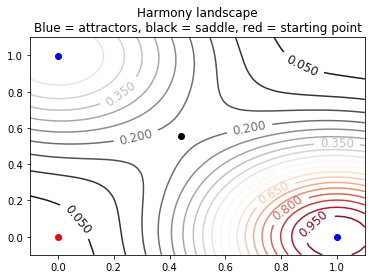

In [4]:
# Plotting the harmony landscape and fixed points
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Hnum = lambdify(x, H)  # Making a numerical version of the symbolic function
delta = 0.025  # Grid size for calculating the harmony
xx1 = np.arange(-0.1, 1.1, delta)
xx2 = np.arange(-0.1, 1.1, delta)
Z = np.zeros((len(xx1), len(xx2)))  # Harmony
for i, j in product(range(len(xx1)), range(len(xx2))):
    Z[i, j] = Hnum(xx1[i], xx2[j])


# Making the contour plot
clines = plt.contour(xx1, xx2, Z.T, 20, cmap='RdGy_r')
plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
# Marking the fixed pts.
plt.plot(xg[0], xg[1], marker='o', color='blue')
plt.plot(xu[0], xu[1], marker='o', color='blue')
plt.plot(xmid[0], xmid[1], marker='o', color='k')
plt.plot(0, 0, marker='o', color='red')  # init. condition
plt.title('Harmony landscape\nBlue = attractors, black = saddle, red = starting point')
plt.show()

In [6]:
# Now we can calculate the integral shown above
# Takes a few seconds...
integrand = Matrix(np.reciprocal(dxdt.subs({x0: r[0], x1: r[1]})))
integrand.dot(dr)  # 
integrand_g = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xg[0]-0.1, x1f: xg[1]-0.1})
Tg = Integral(integrand_g, (t, 0, 1)).evalf()
integrand_u = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to grammatical = {}\nTime to ungrammatical = {}'.format(Tg, Tu))

Time to grammatical = 0.618841121217809
Time to ungrammatical = 2.24774354722145


In [8]:
# Changing the harmony height of the ungrammatical parse:
integrand_u = (integrand.dot(dr)).subs({h1: 0.25, x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu2 = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to ungrammatical (h1 = 0.25) = {}'.format(Tu2))

Time to ungrammatical (h1 = 0.25) = 5.58320971411626


### Summing up so far

So, it looks like the line integral approach is making coherent predictions about settling times to different attractors: Higher-harmony attractors are approached faster than lower-harmony ones.

The overall theory of reading times here is that the overall average time is the weighted average of how long it takes to settle to each attractor weighted by how often the system goes to that attractor. We now have predictions about how fast it takes to get to each attractor, now we want to look at how often it goes to each one.

## Part the second: Relative harmony heights and reading times

Here's the plan for this part: Start with the two harmony peaks at the same height $h_0 = h_1 = 1.0$. Do 2000 runs (using 1000 was still a bit noisy) with $\mathbf{x}_{init} = [0, 0]^\intercal$, $h_0 = 1.0$, and $\gamma = 0.25$, recording which attractor is chosen and how long it takes. After that, I'll gradually lower $h_1$ in increments of 0.05. The hope is that the mean RT for all runs will decrease as $h_1 \rightarrow 0.0$. The lower harmony of $\mathbf{x}_1$ should, on the one hand, make approaches to it much slower, on the other hand, $\mathbf{x}_0$ will be chosen more often, so the average RT should go down.

In [155]:
# Running the Monte-Carlo simulations
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 2000
data_list = []
hvals = np.arange(1.0, 0.0, -0.05)

for h in range(len(hvals)):
    harmonies[1] = hvals[h]
    print('\nh_1 = {}'.format(hvals[h]))
    for run in range(nruns):
        if run % 500 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([hvals[h], 'A', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([hvals[h], 'B', t])
        else:
            data_list.append([hvals[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 1.0
[0] [500] [1000] [1500] 
h_1 = 0.95
[0] [500] [1000] [1500] 
h_1 = 0.8999999999999999
[0] [500] [1000] [1500] 
h_1 = 0.8499999999999999
[0] [500] [1000] [1500] 
h_1 = 0.7999999999999998
[0] [500] [1000] [1500] 
h_1 = 0.7499999999999998
[0] [500] [1000] [1500] 
h_1 = 0.6999999999999997
[0] [500] [1000] [1500] 
h_1 = 0.6499999999999997
[0] [500] [1000] [1500] 
h_1 = 0.5999999999999996
[0] [500] [1000] [1500] 
h_1 = 0.5499999999999996
[0] [500] [1000] [1500] 
h_1 = 0.49999999999999956
[0] [500] [1000] [1500] 
h_1 = 0.4499999999999995
[0] [500] [1000] [1500] 
h_1 = 0.39999999999999947
[0] [500] [1000] [1500] 
h_1 = 0.3499999999999994
[0] [500] [1000] [1500] 
h_1 = 0.2999999999999994
[0] [500] [1000] [1500] 
h_1 = 0.24999999999999933
[0] [500] [1000] [1500] 
h_1 = 0.1999999999999993
[0] [500] [1000] [1500] 
h_1 = 0.14999999999999925
[0] [500] [1000] [1500] 
h_1 = 0.0999999999999992
[0] [500] [1000] [1500] 
h_1 = 0.049999999999999156
[0] [500] [1000] [1500] 

In [156]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0       1.0         B   132
0       1.0         B   166
0       1.0         B   153
0       1.0         A   167
0       1.0         B   143
   Harmony1 Attractor  Time
0      0.05         A   149
0      0.05         A   124
0      0.05         A   140
0      0.05         A   157
0      0.05         A   192


In [157]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                        
           count      mean        std    min    25%    50%    75%    max
Harmony1                                                                
0.05      2000.0  143.3325  20.395880  104.0  129.0  141.0  154.0  357.0
0.10      2000.0  143.9145  20.891468  102.0  130.0  140.0  155.0  250.0
0.15      2000.0  144.0910  20.401049  104.0  130.0  141.0  155.0  256.0
0.20      2000.0  144.7535  20.394845  101.0  131.0  142.0  156.0  261.0
0.25      2000.0  145.6205  21.127889  101.0  131.0  142.0  157.0  321.0
0.30      2000.0  146.0755  21.700766  100.0  131.0  143.0  158.0  366.0
0.35      2000.0  147.0780  21.899445   99.0  132.0  144.0  158.0  360.0
0.40      2000.0  147.2330  22.487275   96.0  132.0  144.0  158.0  337.0
0.45      2000.0  148.8180  23.967647  102.0  133.0  145.0  159.0  314.0
0.50      2000.0  150.1070  26.892493  100.0  132.0  145.0  161.0  388.0
0.55      2000.0  150.2740  24.777063  100.0  134.0  146.0  162.0  300.0
0.60      2000.0  153.0835  26.192204  104.0  135.0  148.0  165.0  293.0
0.65      2000.0  155.7015  28.129967  102.0  136.0  150.0  170.0  331.0
0.70      2000.0  156.5820  27.917180  103.0  136.0  151.0  171.0  337.0
0.75      2000.0  158.1910  27.808977   97.0  138.0  153.0  174.0  307.0
0.80      2000.0  157.9425  26.118447  102.0  139.0  154.0  173.0  295.0
0.85      2000.0  159.9355  27.034862  100.0  140.0  155.0  176.0  291.0
0.90      2000.0  157.7855  25.944615   97.0  140.0  154.0  171.0  392.0
0.95      2000.0  156.1750  24.527865  104.0  139.0  153.0  169.0  264.0
1.00      2000.0  153.9270  23.272161  102.0  137.0  151.0  167.0  266.0

In [158]:
data.groupby(['Attractor', 'Harmony1']).describe()  # basic info by attractor

Time                                               \
                     count        mean        std    min     25%    50%   
Attractor Harmony1                                                        
A         0.05      2000.0  143.332500  20.395880  104.0  129.00  141.0   
          0.10      2000.0  143.914500  20.891468  102.0  130.00  140.0   
          0.15      2000.0  144.091000  20.401049  104.0  130.00  141.0   
          0.20      2000.0  144.753500  20.394845  101.0  131.00  142.0   
          0.25      2000.0  145.620500  21.127889  101.0  131.00  142.0   
          0.30      1999.0  145.965483  21.140938  100.0  131.00  143.0   
          0.35      2000.0  147.078000  21.899445   99.0  132.00  144.0   
          0.40      1998.0  147.084084  21.961635   96.0  132.00  144.0   
          0.45      1992.0  148.343373  22.741390  102.0  133.00  145.0   
          0.50      1981.0  148.931853  23.914851  100.0  132.00  145.0   
          0.55      1977.0  149.239251  22.784702  100.0  133.00  146.0   
          0.60      1957.0  151.493613  23.660810  104.0  135.00  147.0   
          0.65      1902.0  152.465825  23.779091  102.0  135.00  148.0   
          0.70      1840.0  152.610870  23.954272  103.0  135.00  149.0   
          0.75      1757.0  153.305065  24.069027   97.0  136.00  149.0   
          0.80      1650.0  152.866667  23.709847  102.0  136.00  149.0   
          0.85      1506.0  153.729748  24.347225  100.0  136.00  150.0   
          0.90      1351.0  153.452258  24.696659   97.0  136.00  150.0   
          0.95      1156.0  153.630623  24.168838  104.0  136.00  150.0   
          1.00       990.0  153.383838  22.545183  107.0  137.00  150.0   
B         0.30         1.0  366.000000        NaN  366.0  366.00  366.0   
          0.40         2.0  296.000000  57.982756  255.0  275.50  296.0   
          0.45         8.0  267.000000  30.355042  221.0  246.25  268.0   
          0.50        19.0  272.631579  37.504386  227.0  247.50  268.0   
          0.55        23.0  239.217391  28.040485  189.0  223.50  239.0   
          0.60        43.0  225.441860  33.187277  160.0  201.00  216.0   
          0.65        98.0  218.500000  32.187675  157.0  195.00  214.0   
          0.70       160.0  202.250000  29.675393  147.0  182.00  198.0   
          0.75       243.0  193.518519  27.529598  144.0  173.00  190.0   
          0.80       350.0  181.871429  23.561735  131.0  166.00  179.0   
          0.85       494.0  178.854251  26.031714  119.0  160.00  176.0   
          0.90       649.0  166.805855  26.176029  116.0  150.00  163.0   
          0.95       844.0  159.659953  24.601773  111.0  142.00  156.0   
          1.00      1010.0  154.459406  23.962575  102.0  137.00  151.5   

                                   
                       75%    max  
Attractor Harmony1                 
A         0.05      154.00  357.0  
          0.10      155.00  250.0  
          0.15      155.00  256.0  
          0.20      156.00  261.0  
          0.25      157.00  321.0  
          0.30      158.00  287.0  
          0.35      158.00  360.0  
          0.40      158.00  288.0  
          0.45      159.00  314.0  
          0.50      160.00  285.0  
          0.55      161.00  300.0  
          0.60      163.00  287.0  
          0.65      165.00  289.0  
          0.70      165.00  337.0  
          0.75      167.00  277.0  
          0.80      166.00  295.0  
          0.85      165.00  291.0  
          0.90      166.00  273.0  
          0.95      166.00  264.0  
          1.00      165.00  266.0  
B         0.30      366.00  366.0  
          0.40      316.50  337.0  
          0.45      291.75  305.0  
          0.50      287.00  388.0  
          0.55      249.50  296.0  
          0.60      252.50  293.0  
          0.65      236.00  331.0  
          0.70      219.50  297.0  
          0.75      210.00  307.0  
          0.80      196.00  259.0  
          0.85      194.00  288.0  
          0.90      18

In [162]:
# Calculating descriptive statistics for plotting
byharmony = data.groupby(['Harmony1', 'Attractor']).agg('count')
props = byharmony.groupby(level=0).apply(lambda x: x / x.sum())
propa = props.xs('A', level=1)  # Proportions of A-parses by h1 harmony

means = data.groupby('Harmony1').describe().iloc[:, 1]  # Mean settling times

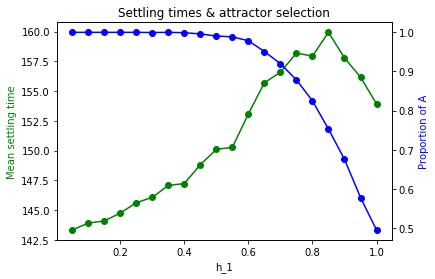

In [164]:
# Making a figure of mean settling time and proportion of A attractors
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(hvals[::-1], means, 'g-o')
ax2.plot(hvals[::-1], propa, 'b-o')

ax1.set_xlabel('h_1')
ax1.set_ylabel('Mean settling time', color='g')
ax2.set_ylabel('Proportion of A', color='b')
plt.title('Settling times & attractor selection')
plt.show()

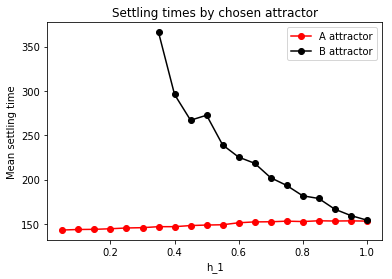

In [167]:
# Looking at the settling times by attractor chosen and h1
rts = data.groupby(['Attractor', 'Harmony1']).describe().iloc[:, 1]
plt.plot(hvals[::-1], rts.xs('A'), 'r-o', label='A attractor')
plt.plot(hvals[0:14,][::-1], rts.xs('B'), 'k-o', label='B attractor')
plt.title('Settling times by chosen attractor')
plt.ylabel('Mean settling time')
plt.xlabel('h_1')
plt.legend()
plt.show()


## Discussion

In this second part, we see an unexpected nonlinear relationship between the relative harmony heights and the settling times. One part of our expectation was borne out: When one attractor has high harmony and the other attractor has low harmony, the average settling times were fast. The system always chooses the high-harmony attractor, and it gets there fast due to its high harmony.

As the harmony of the lower-harmony peak increases, so does the average settling time. But this pattern only holds for a while. After the lower-harmony peak reaches about $h_1 = 0.9$, the average settling time starts to *decrease*. This is because the system starts choosing the lower-harmony peak more often at the same as it's getting faster to approach that attractor. When the two attractors have equal harmony (1.0), the average reading time is still higher than when the two were very unbalanced in harmony.

This makes a really interesting and, as far as I know, unique prediction for sentence processing. When there are two parses available, one high- and one low-harmony, reading times should be fast because the parser will easily choose the high-harmony parse. Reading times should be slower when the two parses are evenly matched in harmony. But this  competition-based slowdown should actually be stronger when the competing parses are only slightly unbalanced in their well-formedness.